In [39]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFECV

from data_handle import get_data_and_preprocess, cut_data, translate_to_ints, dic_attacks

%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset loading

In [4]:
normal_network, normal_energy = get_data_and_preprocess('normal', 'archer')
mirai_network, mirai_energy = get_data_and_preprocess('mirai', 'archer')

In [5]:
normal_network

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
670,1783.318520,8.8.8.8,172.31.1.15,DNS,94,0.22,normal
671,1785.845176,172.31.1.15,8.8.8.8,DNS,68,0.22,normal
672,1785.858714,8.8.8.8,172.31.1.15,DNS,100,0.22,normal
673,1790.909397,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.21,normal


In [6]:
normal_energy

,energy,time
0,0.00,0
1,0.00,1
2,0.06,2
3,0.11,3
4,0.12,4
...,...,...
1792,0.22,1792
1793,0.22,1793
1794,0.22,1794
1795,0.23,1795


In [7]:
# Get all datasets in the same time-frame
normal_network, normal_energy, mirai_network, mirai_energy = cut_data(normal_network, normal_energy, mirai_network, mirai_energy)

## Energy usage

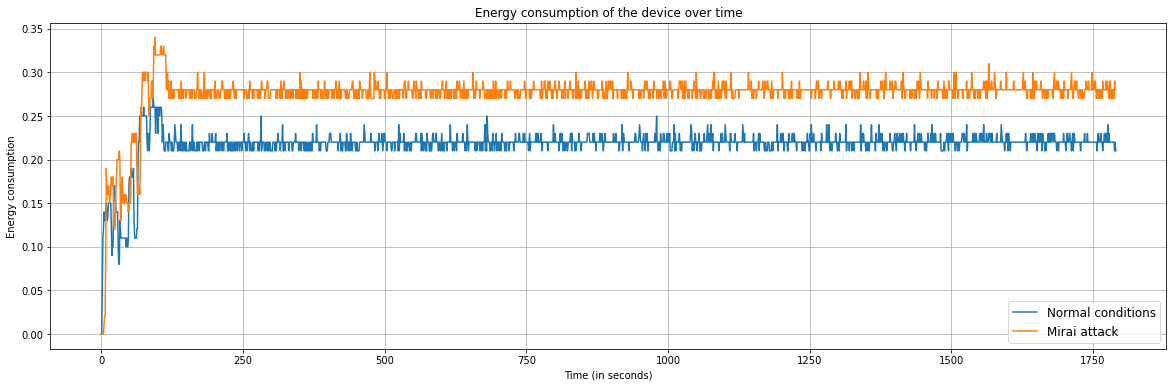

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

ax.plot(normal_energy['time'], normal_energy['energy'], label='Normal conditions')
ax.plot(mirai_energy['time'], mirai_energy['energy'], label='Mirai attack')
ax.set_title('Energy consumption of the device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

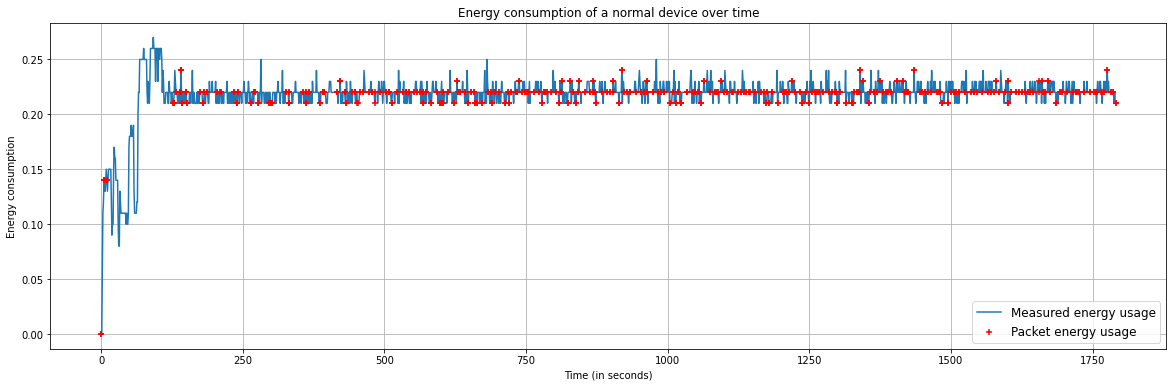

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)

max_time = min(normal_energy['time'].max(), mirai_energy['time'].max())

ax.plot(normal_energy['time'], normal_energy['energy'], label='Measured energy usage')
ax.scatter(normal_network['Time'], normal_network['energy'], label='Packet energy usage', c='r', marker='+', zorder=10)
ax.set_title('Energy consumption of a normal device over time')
ax.set_xlabel('Time (in seconds)')
ax.set_ylabel('Energy consumption')
ax.legend(loc=4, prop={'size': 12})
ax.grid()

## Protocol study

In [10]:
# normal_network = normal_network[normal_network.Protocol != 'ICMP']
# mirai_network = mirai_network[mirai_network.Protocol != 'ICMP']

print("Protocols:", normal_network['Protocol'].unique())

Protocols: ['DNS' 'ARP' 'DHCP' 'ICMP' 'TCP' 'TLSv1.2' 'NTP']


In [11]:
print("Count of the packets of each protocol")
df = pd.DataFrame()
df['Normal'] = normal_network.groupby('Protocol').count()['Length']
df['Mirai attack'] = mirai_network.groupby('Protocol').count()['Length']
df

Count of the packets of each protocol


,Normal,Mirai attack
Protocol,,
ARP,178,200
DHCP,12,12
DNS,430,464
ICMP,1,244
NTP,4,4
TCP,32,437950
TLSv1.2,18,30


<AxesSubplot:title={'center':'Bar graph for each protocol in normal communications'}, ylabel='Count'>

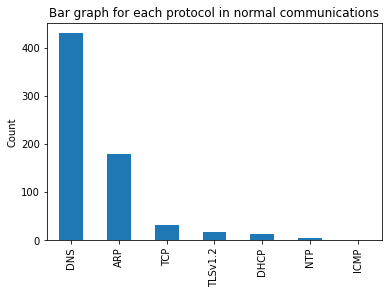

In [12]:
normal_network['Protocol'].value_counts().plot.bar(title="Bar graph for each protocol in normal communications", ylabel="Count")

## Getting data ready for the model

In [14]:
normal_network.corr()

,Time,Length,energy
Time,1.000000,-0.105717,0.104204
Length,-0.105717,1.000000,0.052379
energy,0.104204,0.052379,1.000000


In [34]:
Final_merge_readable = normal_network.append(mirai_network)
Final_merge_readable = Final_merge_readable[Final_merge_readable.Protocol != 0]
Final_merge_readable

/tmp/ipykernel_6864/1347146614.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Final_merge_readable = normal_network.append(mirai_network)


,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,172.31.1.15,8.8.8.8,DNS,71,0.00,normal
1,0.020682,8.8.8.8,172.31.1.15,DNS,135,0.00,normal
2,5.002782,Tp-LinkT_81:9e:53,PcsCompu_73:1d:1d,ARP,60,0.14,normal
3,5.002810,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
4,5.053399,PcsCompu_73:1d:1d,Tp-LinkT_81:9e:53,ARP,42,0.14,normal
...,...,...,...,...,...,...,...
438901,1786.267402,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438902,1786.267408,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438903,1786.267413,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai
438904,1786.267417,172.31.0.17,172.31.1.15,TCP,74,0.28,mirai


In [37]:
Final_merge_readable.groupby('Protocol').count()['Time']

Protocol
ARP           378
DHCP           24
DNS           894
ICMP          245
ICMPv6          2
NTP             8
TCP        437982
TLSv1.2        48
Name: Time, dtype: int64

In [36]:
Final_merge = translate_to_ints(Final_merge_readable.copy())
Final_merge

,Time,Source,Destination,Protocol,Length,energy,target
0,0.000000,7,12,0,71,0.00,0
1,0.020682,12,6,0,135,0.00,0
2,5.002782,14,14,1,60,0.14,0
3,5.002810,13,15,1,42,0.14,0
4,5.053399,13,15,1,42,0.14,0
...,...,...,...,...,...,...,...
438901,1786.267402,5,6,4,74,0.28,1
438902,1786.267408,5,6,4,74,0.28,1
438903,1786.267413,5,6,4,74,0.28,1
438904,1786.267417,5,6,4,74,0.28,1


In [18]:
Final_merge.to_csv('QRS_dataset/FinalSet.csv')

## Random Forest

In [19]:
# Target variable and train set
y = Final_merge[['target']]
X = Final_merge.drop(['target', ], axis = 1)

# Split test and train data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 42)
print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 175832
Test size:  263749


In [38]:
clf = RandomForestClassifier(5)
clf.fit(X_train, y_train['target'])

RandomForestClassifier(n_estimators=5)

In [40]:
print("Original mirai packet share:", mirai_network.shape[0]/(normal_network.shape[0]+mirai_network.shape[0]))

print("Score:", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)

dic_attacks_inv = {v:k for k,v in dic_attacks.items()}

unique, counts = np.unique(y_pred, return_counts=True)
unique = [dic_attacks_inv[u] for u in unique]
df = pd.DataFrame(index=unique)
df['predicted'] = counts
unique, counts = np.unique(y_test, return_counts=True)
df['actual'] = counts
df

Original mirai packet share: 0.9984644468254997
Score: 0.9999886255492911


,predicted,actual
normal,401,402
mirai,263348,263347


In [41]:
clf_cv_score = cross_val_score(clf, X, y['target'], cv=10, scoring='roc_auc')
clf_cv_score

array([0.99862443, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [ ]:
print("=================== Confusion Matrix ======================")
print(metrics.confusion_matrix(y_test, y_pred))
print('\n') 
print("=================== Classification Report =================")
print(metrics.classification_report(y_test, y_pred))
print('\n') 
print("=================== All AUC Scores =======================")
print(clf_cv_score)
print('\n') 
print("=================== Mean AUC Score =======================")
print("Mean AUC Score - Random Forest: ", clf_cv_score.mean())

=================== Confusion Matrix ======================
[[   399      3]
 [     2 263345]]


=================== Classification Report =================
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       402
           1       1.00      1.00      1.00    263347

    accuracy                           1.00    263749
   macro avg       1.00      1.00      1.00    263749
weighted avg       1.00      1.00      1.00    263749



=================== All AUC Scores =======================
[0.99863013 1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


=================== Mean AUC Score =======================
Mean AUC Score - Random Forest:  0.999863012918366


In [ ]:
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)

Score list: [8.37216346e+03 1.34653306e+03 6.83566397e+02 7.30046739e+02
 4.21591787e+03 3.50055064e+00]
Feature list: Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'energy'], dtype='object')


In [ ]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier(5) 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train['target'])

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 6
Best features : Index(['Time', 'Source', 'Destination', 'Protocol', 'Length', 'energy'], dtype='object')


In [ ]:
rfecv.grid_scores_

/home/alexis/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


array([[0.99997156, 1.        , 1.        , 1.        , 0.99997156],
       [0.99994313, 1.        , 1.        , 0.99991469, 0.99994313],
       [0.99997156, 1.        , 1.        , 0.99991469, 0.99997156],
       [0.99994313, 1.        , 1.        , 0.99988625, 0.99997156],
       [0.99994313, 0.99994313, 1.        , 0.99991469, 0.99997156],
       [0.99997156, 1.        , 1.        , 1.        , 1.        ]])

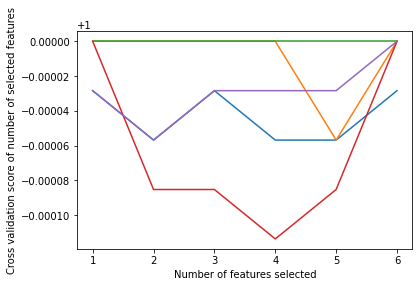

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

/tmp/ipykernel_6263/1353532891.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clr_rf_5 = clf_rf_5.fit(X_train,y_train)


Feature ranking:
1. feature 5 (0.545167)
2. feature 3 (0.173052)
3. feature 0 (0.105926)
4. feature 1 (0.079264)
5. feature 2 (0.066381)
6. feature 4 (0.030210)


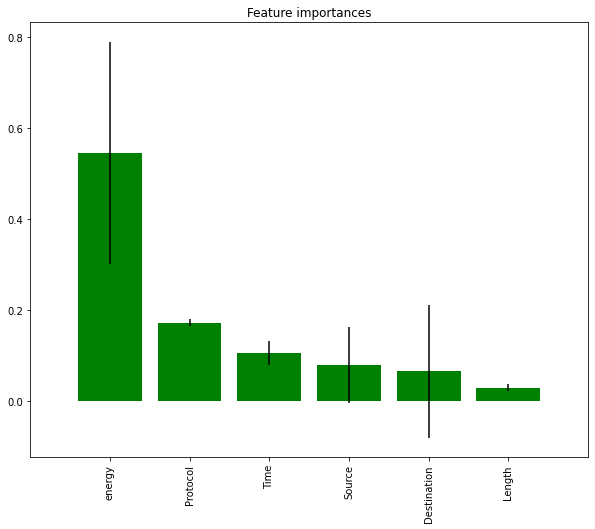

In [ ]:
clf_rf_5 = RandomForestClassifier(5)
clr_rf_5 = clf_rf_5.fit(X_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
#plt.savefig('books_read.png')

## Federated

Check out the folder `flower test`